In [1]:
import os
import zarr
import timm
import random
import json
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
import sys
import torch
from torch.cuda.amp import autocast, GradScaler

# import torchvision.transforms.functional as F
import random

warnings.filterwarnings("ignore")
sys.path.append("./src/")

from src.config import CFG
from src.dataloader import (
    read_zarr,
    read_info_json,
    scale_coordinates,
    create_dataset,
    create_segmentation_map,
    EziiDataset,
    drop_padding,
)
from src.network import Unet3D
from src.utils import save_images, PadToSize
from src.metric import (
    score,
    create_cls_pos,
    create_cls_pos_sikii,
    create_df,
    SegmentationLoss,
    DiceLoss,
)
from src.inference import inference, inference2pos, create_gt_df
from metric import visualize_epoch_results

In [2]:
train_dataset = EziiDataset(
    exp_names=CFG.train_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.train_zarr_types,
    train=True,
    augmentation=True,
    slice=True,
    pre_read=True,
)

# train_nshuffle_dataset = EziiDataset(
#     exp_names=CFG.train_exp_names,
#     base_dir="../../inputs/train/",
#     particles_name=CFG.particles_name,
#     resolution=CFG.resolution,
#     zarr_type=CFG.train_zarr_types,
#     augmentation=False,
#     train=True,
# )

valid_dataset = EziiDataset(
    exp_names=CFG.valid_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.valid_zarr_types,
    augmentation=False,
    train=True,
    slice=True,
    pre_read=True,
)

from tqdm import tqdm

train_loader = DataLoader(
    train_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=CFG.num_workers,
)
# train_nshuffle_loader = DataLoader(
#     train_nshuffle_dataset,
#     batch_size=1,
#     shuffle=True,
#     drop_last=True,
#     pin_memory=True,
#     num_workers=CFG.num_workers,
# )
valid_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
    num_workers=CFG.num_workers,
)

for data in tqdm(train_loader):
    normalized_tomogram = data["normalized_tomogram"]
    segmentation_map = data["segmentation_map"]
    break

normalized_tomogram.shape

  0%|          | 0/88 [00:04<?, ?it/s]


torch.Size([3, 16, 630, 630])

In [3]:
encoder = timm.create_model(
    model_name=CFG.model_name,
    pretrained=True,
    in_chans=3,
    num_classes=0,
    global_pool="",
    features_only=True,
)
model = Unet3D(encoder=encoder).to("cuda")
# model.load_state_dict(torch.load("./pretrained_model.pth"))
# model.load_state_dict(torch.load("./best_model.pth"))

In [4]:
# input-test

x = torch.randn(2, 16, 1, 64, 64).cuda()
model(x).shape

torch.Size([2, 7, 16, 64, 64])

In [5]:
# # "encoder"と名のつくパラメータは学習しない
# for layer, param in model.named_parameters():
#     if "encoder" in layer:
#         param.requires_grad = False

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# サンプルデータ
num_classes = len(CFG.particles_name)  # クラス数
colors = plt.cm.tab10(
    np.arange(len(CFG.particles_name))
)  # "tab10" カラーマップから色を取得

# ListedColormap を作成
class_colormap = ListedColormap(colors)


# カラーバー付きプロット
def plot_with_colormap(data, title, original_tomogram):
    masked_data = np.ma.masked_where(data <= 0, data)  # クラス0をマスク
    plt.imshow(original_tomogram, cmap="gray")
    im = plt.imshow(masked_data, cmap=class_colormap)
    plt.title(title)
    plt.axis("off")
    return im

In [7]:
import torch
import random
import torchvision.transforms.functional as TF


# 回転
# 3Dテンソルの各軸に対して指定した角度で回転する関数
def rotate_3d(tomogram, segmentation_map, angle):
    """Rotates the 3D tensors tomogram and segmentation_map around the Z-axis."""
    rotated_tomogram = TF.rotate(tomogram, angle, expand=False)
    rotated_segmentation_map = TF.rotate(segmentation_map, angle, expand=False)
    return rotated_tomogram, rotated_segmentation_map


# 平行移動
# 指定された範囲でランダムに平行移動
def translate_3d(tomogram, segmentation_map, max_shift):
    """Translates the 3D tensors by a random shift within max_shift."""
    shift_x = random.randint(-max_shift, max_shift)
    shift_y = random.randint(-max_shift, max_shift)
    translated_tomogram = TF.affine(
        tomogram, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    translated_segmentation_map = TF.affine(
        segmentation_map, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    return translated_tomogram, translated_segmentation_map


# フリップ
# 縦横（上下左右）ランダムフリップ
def flip_3d(tomogram, segmentation_map):
    """Randomly flips the 3D tensors along height or width."""
    if random.random() > 0.5:  # Horizontal flip
        tomogram = torch.flip(tomogram, dims=[-1])
        segmentation_map = torch.flip(segmentation_map, dims=[-1])
    if random.random() > 0.5:  # Vertical flip
        tomogram = torch.flip(tomogram, dims=[-2])
        segmentation_map = torch.flip(segmentation_map, dims=[-2])
    return tomogram, segmentation_map


# クロッピング
# 入力テンソルを中心またはランダムクロップで切り取る
def crop_3d(tomogram, segmentation_map, crop_size):
    """Crops the 3D tensors to the specified crop_size."""
    _, depth, height, width = tomogram.size()
    crop_d, crop_h, crop_w = crop_size

    if crop_h > height or crop_w > width:
        raise ValueError("Crop size cannot be larger than the original size.")

    start_h = random.randint(0, height - crop_h)  # Random starting position for height
    start_w = random.randint(0, width - crop_w)  # Random starting position for width

    cropped_tomogram = tomogram[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]
    cropped_segmentation_map = segmentation_map[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]

    return cropped_tomogram, cropped_segmentation_map


# Mixup
# 2つのサンプルを線形補間して混合
def mixup(tomogram, segmentation_map, alpha=0.4):
    """Applies mixup augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size = tomogram.size(0)
    index = torch.randperm(batch_size)

    mixed_tomogram = lam * tomogram + (1 - lam) * tomogram[index, :]
    mixed_segmentation_map = (
        lam * segmentation_map + (1 - lam) * segmentation_map[index, :]
    )

    return mixed_tomogram, mixed_segmentation_map


# Cutmix
# ランダム領域を切り取って別のサンプルに貼り付け
def cutmix(tomogram, segmentation_map, alpha=1.0):
    """Applies cutmix augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size, depth, height, width = tomogram.size()
    index = torch.randperm(batch_size)

    cx = random.randint(0, width)
    cy = random.randint(0, height)
    cw = int(width * (1 - lam))
    ch = int(height * (1 - lam))

    x1 = max(cx - cw // 2, 0)
    x2 = min(cx + cw // 2, width)
    y1 = max(cy - ch // 2, 0)
    y2 = min(cy + ch // 2, height)

    tomogram[:, :, y1:y2, x1:x2] = tomogram[index, :, y1:y2, x1:x2]
    segmentation_map[:, :, y1:y2, x1:x2] = segmentation_map[index, :, y1:y2, x1:x2]

    return tomogram, segmentation_map


# データ拡張の組み合わせ適用
def augment_data(
    tomogram,
    segmentation_map,
    crop_size=(16, 256, 256),
    max_shift=10,
    rotation_angle=30,
    p=0.5,
    mixup_alpha=0.4,
    cutmix_alpha=1.0,
):
    """Applies a combination of rotation, translation, flipping, cropping, mixup, and cutmix to the inputs with probabilities."""
    if random.random() < p:
        tomogram, segmentation_map = rotate_3d(
            tomogram,
            segmentation_map,
            angle=random.uniform(-rotation_angle, rotation_angle),
        )
    if random.random() < p:
        tomogram, segmentation_map = translate_3d(
            tomogram, segmentation_map, max_shift=max_shift
        )
    if random.random() < p:
        tomogram, segmentation_map = flip_3d(tomogram, segmentation_map)
    if random.random() < p:
        tomogram, segmentation_map = crop_3d(
            tomogram, segmentation_map, crop_size=crop_size
        )
    if random.random() < p:
        tomogram, segmentation_map = mixup(
            tomogram, segmentation_map, alpha=mixup_alpha
        )
    # if random.random() < p:
    #     tomogram, segmentation_map = cutmix(
    #         tomogram, segmentation_map, alpha=cutmix_alpha
    #     )
    return tomogram, segmentation_map


# 使用例
# バッチサイズ6, 深さ16, 高さ320, 幅320のランダムテンソル
tomogram = torch.rand((6, 16, 320, 320))
segmentation_map = torch.randint(0, 2, (6, 16, 320, 320))  # ラベルは0または1

# データ拡張の適用
aug_tomogram, aug_segmentation_map = augment_data(tomogram, segmentation_map, p=0.7)
print("Original shape:", tomogram.shape)
print("Augmented shape:", aug_tomogram.shape)

Original shape: torch.Size([6, 16, 320, 320])
Augmented shape: torch.Size([6, 16, 320, 320])


In [8]:
from transformers import get_cosine_schedule_with_warmup

optimizer = torch.optim.Adam(
    model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay
)
criterion = nn.CrossEntropyLoss(
    #  weight=torch.tensor([2.0, 32, 32, 32, 32, 32, 32]).to("cuda")
)
# criterion = DiceLoss()
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=10,
    num_training_steps=CFG.epochs * len(train_loader),
    # * batch_size,
)
scaler = GradScaler()
seg_loss = SegmentationLoss(criterion)
padf = PadToSize(CFG.resolution)

In [9]:
# b, c, d, h, w = CFG.batch_size, 1, 96, 320, 320

In [10]:
def preprocess_tensor(tensor):
    batch_size, depth, height, width = tensor.shape
    tensor = tensor.unsqueeze(2)  # (b, d, h, w) -> (b, d, 1, h, w)
    return tensor

In [11]:
padf = PadToSize(CFG.resolution)
padf(normalized_tomogram).shape

torch.Size([3, 16, 640, 640])

In [12]:
best_model = None
best_constant = 0
best_score = -100

grand_train_loss = []
grand_valid_loss = []
grand_train_score = []
grand_valid_score = []

for epoch in range(CFG.epochs):
    model.train()
    train_loss = []
    valid_loss = []
    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Training]") as tq:
        for data in tq:
            normalized_tomogram = data["normalized_tomogram"]
            segmentation_map = data["segmentation_map"]

            normalized_tomogram = padf(normalized_tomogram)
            segmentation_map = padf(segmentation_map)

            # データ拡張
            normalized_tomogram, segmentation_map = augment_data(
                normalized_tomogram, segmentation_map, p=CFG.augmentation_prob
            )
            normalized_tomogram = normalized_tomogram.cuda()
            segmentation_map = segmentation_map.long().cuda()

            optimizer.zero_grad()

            with autocast():
                pred = model(preprocess_tensor(normalized_tomogram))
                loss = seg_loss(pred, segmentation_map)
            # loss.backward()
            # optimizer.step()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            train_loss.append(loss.item())

            # 確率予測
            prob_pred = torch.softmax(pred, dim=1)
            tq.set_postfix({"loss": f"{np.mean(train_loss):.4f}"})

    with tqdm(valid_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Validation]") as tq:
        for data in tq:
            normalized_tomogram = data["normalized_tomogram"].cuda()
            segmentation_map = data["segmentation_map"].long().cuda()

            normalized_tomogram = padf(normalized_tomogram)
            segmentation_map = padf(segmentation_map)

            with autocast():
                pred = model(preprocess_tensor(normalized_tomogram))
                loss = seg_loss(pred, segmentation_map)
            valid_loss.append(loss.item())

            # 確率予測
            prob_pred = torch.softmax(pred, dim=1)
            tq.set_postfix({"loss": f"{np.mean(valid_loss):.4f}"})

    # # ############### validation ################
    train_nshuffle_original_tomogram = defaultdict(list)
    train_nshuffle_pred_tomogram = defaultdict(list)
    train_nshuffle_gt_tomogram = defaultdict(list)

    valid_original_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)

    train_mean_scores = []
    valid_mean_scores = []

    # モデルの保存
    torch.save(model.state_dict(), "./pretrained_model.pth")

    # ############### validation ################
    train_nshuffle_original_tomogram = defaultdict(list)
    train_nshuffle_pred_tomogram = defaultdict(list)
    train_nshuffle_gt_tomogram = defaultdict(list)

    valid_original_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)

    train_mean_scores = []
    valid_mean_scores = []

    train_inferenced_array = {}
    train_pred_array = []
    train_gt_array = []
    valid_inferenced_array = {}
    valid_gt_array = []

    # for exp_name in tqdm(CFG.train_exp_names):
    for exp_name in [CFG.valid_exp_name]:  # 5つのデータで試す
        # inferenced_array = inference(model, exp_name, train=False)
        inferenced_array, n_tomogram, segmentation_map = inference(
            model, exp_name, train=False
        )
        valid_inferenced_array[exp_name] = inferenced_array
        base_dir = "../../inputs/train/overlay/ExperimentRuns/"
        gt_df = create_gt_df(base_dir, [exp_name])
        valid_gt_array.append(gt_df)

    valid_gt_array = pd.concat(valid_gt_array)

    b_constant = 0
    b_score = -100
    for constant in tqdm(np.linspace(0.1, 0.9, 15)):
        valid_pred_array = []
        sikii = {
            "apo-ferritin": constant,
            "beta-amylase": constant,
            "beta-galactosidase": constant,
            "ribosome": constant,
            "thyroglobulin": constant,
            "virus-like-particle": constant,
        }
        for exp_name in [CFG.valid_exp_name]:  # 5つのデータで試す
            pred_df = inference2pos(
                pred_segmask=valid_inferenced_array[exp_name],
                exp_name=exp_name,
                sikii_dict=sikii,
            )
            valid_pred_array.append(pred_df)

        valid_pred_array = pd.concat(valid_pred_array)

        if len(valid_pred_array) != 0:
            score_ = score(
                valid_pred_array,
                valid_gt_array,
                row_id_column_name="index",
                distance_multiplier=1.0,
                beta=4,
            )
            if score_ > b_score:
                b_score = score_
                b_constant = constant

        import gc
        import torch.cuda as cuda

        gc.collect()
        cuda.empty_cache()

    print("constant", b_constant, "score", b_score)

    if b_score > best_score:
        best_constant = b_constant
        best_score = b_score
        # best_score = np.mean(valid_mean_scores)
        best_model = model.state_dict()
        torch.save(best_model, f"./best_model.pth")

    print(
        f"train-epoch-loss:{np.mean(train_loss):.4f}",
        f"valid-epoch-loss:{np.mean(valid_loss):.4f}",
        # f"train-beta4-score:{np.mean(train_mean_scores):.4f}",
        f"valid-beta4-score:{b_score:.4f}",
    )

    grand_train_loss.append(np.mean(train_loss))
    grand_valid_loss.append(np.mean(valid_loss))
    # grand_train_score.append(np.mean(train_mean_scores))
    grand_valid_score.append(b_score)

100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


constant 0.5 score 0.07596943923886408
train-epoch-loss:1.4938 valid-epoch-loss:0.9799 valid-beta4-score:0.0760


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


constant 0.5571428571428572 score 0.08332132045552833
train-epoch-loss:0.6451 valid-epoch-loss:0.3719 valid-beta4-score:0.0833


100%|██████████| 15/15 [00:33<00:00,  2.24s/it]


constant 0.2142857142857143 score 0.06944976381973701
train-epoch-loss:0.2555 valid-epoch-loss:0.1675 valid-beta4-score:0.0694


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


constant 0.3285714285714286 score 0.10955961331901183
train-epoch-loss:0.1318 valid-epoch-loss:0.0872 valid-beta4-score:0.1096


100%|██████████| 15/15 [00:34<00:00,  2.32s/it]


constant 0.6714285714285715 score 0.13625648279113625
train-epoch-loss:0.0812 valid-epoch-loss:0.0632 valid-beta4-score:0.1363


100%|██████████| 15/15 [00:38<00:00,  2.54s/it]


constant 0.5 score 0.1425775789767962
train-epoch-loss:0.0626 valid-epoch-loss:0.0545 valid-beta4-score:0.1426


100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


constant 0.44285714285714284 score 0.14336825964732938
train-epoch-loss:0.0520 valid-epoch-loss:0.0431 valid-beta4-score:0.1434


100%|██████████| 15/15 [00:32<00:00,  2.15s/it]


constant 0.1 score 0.15603125015682193
train-epoch-loss:0.0411 valid-epoch-loss:0.0381 valid-beta4-score:0.1560


100%|██████████| 15/15 [00:32<00:00,  2.18s/it]


constant 0.15714285714285714 score 0.19797250769244176
train-epoch-loss:0.0390 valid-epoch-loss:0.0175 valid-beta4-score:0.1980


100%|██████████| 15/15 [00:31<00:00,  2.13s/it]


constant 0.3285714285714286 score 0.25862009428311844
train-epoch-loss:0.0356 valid-epoch-loss:0.0355 valid-beta4-score:0.2586


100%|██████████| 15/15 [00:33<00:00,  2.24s/it]


constant 0.27142857142857146 score 0.2700466203068464
train-epoch-loss:0.0338 valid-epoch-loss:0.0095 valid-beta4-score:0.2700


100%|██████████| 15/15 [00:31<00:00,  2.10s/it]


constant 0.27142857142857146 score 0.261266735930057
train-epoch-loss:0.0313 valid-epoch-loss:0.0122 valid-beta4-score:0.2613


100%|██████████| 15/15 [00:32<00:00,  2.18s/it]


constant 0.27142857142857146 score 0.18257988345964885
train-epoch-loss:0.0258 valid-epoch-loss:0.0136 valid-beta4-score:0.1826


100%|██████████| 15/15 [00:31<00:00,  2.13s/it]


constant 0.27142857142857146 score 0.2632532879271636
train-epoch-loss:0.0300 valid-epoch-loss:0.0289 valid-beta4-score:0.2633


100%|██████████| 15/15 [00:34<00:00,  2.29s/it]


constant 0.44285714285714284 score 0.2799879168363125
train-epoch-loss:0.0274 valid-epoch-loss:0.0153 valid-beta4-score:0.2800


100%|██████████| 15/15 [00:32<00:00,  2.17s/it]


constant 0.44285714285714284 score 0.25371369535695837
train-epoch-loss:0.0268 valid-epoch-loss:0.0048 valid-beta4-score:0.2537


100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


constant 0.1 score 0.21517049136398375
train-epoch-loss:0.0275 valid-epoch-loss:0.0173 valid-beta4-score:0.2152


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


constant 0.5 score 0.2798130249255979
train-epoch-loss:0.0257 valid-epoch-loss:0.0036 valid-beta4-score:0.2798


100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


constant 0.44285714285714284 score 0.26548533793319745
train-epoch-loss:0.0273 valid-epoch-loss:0.0033 valid-beta4-score:0.2655


100%|██████████| 15/15 [00:33<00:00,  2.26s/it]


constant 0.15714285714285714 score 0.2716228384016254
train-epoch-loss:0.0248 valid-epoch-loss:0.0226 valid-beta4-score:0.2716


100%|██████████| 15/15 [00:34<00:00,  2.29s/it]


constant 0.3285714285714286 score 0.32000495244193317
train-epoch-loss:0.0265 valid-epoch-loss:0.0100 valid-beta4-score:0.3200


100%|██████████| 15/15 [00:34<00:00,  2.31s/it]


constant 0.2142857142857143 score 0.29092484333794244
train-epoch-loss:0.0263 valid-epoch-loss:0.0119 valid-beta4-score:0.2909


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


constant 0.2142857142857143 score 0.35933379733558146
train-epoch-loss:0.0225 valid-epoch-loss:0.0246 valid-beta4-score:0.3593


100%|██████████| 15/15 [00:34<00:00,  2.32s/it]


constant 0.2142857142857143 score 0.2717076366712717
train-epoch-loss:0.0232 valid-epoch-loss:0.0020 valid-beta4-score:0.2717


100%|██████████| 15/15 [00:33<00:00,  2.26s/it]


constant 0.5571428571428572 score 0.28496241140636347
train-epoch-loss:0.0263 valid-epoch-loss:0.0078 valid-beta4-score:0.2850


100%|██████████| 15/15 [00:33<00:00,  2.24s/it]


constant 0.6142857142857143 score 0.2773821695276019
train-epoch-loss:0.0220 valid-epoch-loss:0.0238 valid-beta4-score:0.2774


100%|██████████| 15/15 [00:35<00:00,  2.35s/it]


constant 0.5 score 0.4486483732069607
train-epoch-loss:0.0224 valid-epoch-loss:0.0178 valid-beta4-score:0.4486


100%|██████████| 15/15 [00:33<00:00,  2.26s/it]


constant 0.7285714285714286 score 0.2897357136340135
train-epoch-loss:0.0235 valid-epoch-loss:0.0053 valid-beta4-score:0.2897


100%|██████████| 15/15 [00:34<00:00,  2.30s/it]


constant 0.1 score 0.3862211947092829
train-epoch-loss:0.0240 valid-epoch-loss:0.0200 valid-beta4-score:0.3862


100%|██████████| 15/15 [00:34<00:00,  2.32s/it]


constant 0.44285714285714284 score 0.4532247940830212
train-epoch-loss:0.0215 valid-epoch-loss:0.0066 valid-beta4-score:0.4532


100%|██████████| 15/15 [00:35<00:00,  2.33s/it]


constant 0.2142857142857143 score 0.4564398987928598
train-epoch-loss:0.0196 valid-epoch-loss:0.0222 valid-beta4-score:0.4564


100%|██████████| 15/15 [00:34<00:00,  2.33s/it]


constant 0.2142857142857143 score 0.39480503911618536
train-epoch-loss:0.0177 valid-epoch-loss:0.0108 valid-beta4-score:0.3948


100%|██████████| 15/15 [00:35<00:00,  2.35s/it]


constant 0.27142857142857146 score 0.40276190373137205
train-epoch-loss:0.0207 valid-epoch-loss:0.0227 valid-beta4-score:0.4028


100%|██████████| 15/15 [00:34<00:00,  2.31s/it]


constant 0.3285714285714286 score 0.4978385515515909
train-epoch-loss:0.0197 valid-epoch-loss:0.0191 valid-beta4-score:0.4978


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


constant 0.3285714285714286 score 0.5369708585510385
train-epoch-loss:0.0182 valid-epoch-loss:0.0207 valid-beta4-score:0.5370


100%|██████████| 15/15 [00:34<00:00,  2.31s/it]


constant 0.3857142857142858 score 0.4332505406577424
train-epoch-loss:0.0205 valid-epoch-loss:0.0219 valid-beta4-score:0.4333


100%|██████████| 15/15 [00:34<00:00,  2.32s/it]


constant 0.3285714285714286 score 0.48922040312389975
train-epoch-loss:0.0224 valid-epoch-loss:0.0009 valid-beta4-score:0.4892


100%|██████████| 15/15 [00:35<00:00,  2.40s/it]


constant 0.3857142857142858 score 0.5026183417887006
train-epoch-loss:0.0203 valid-epoch-loss:0.0198 valid-beta4-score:0.5026


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


constant 0.44285714285714284 score 0.5802346670558528
train-epoch-loss:0.0207 valid-epoch-loss:0.0118 valid-beta4-score:0.5802


100%|██████████| 15/15 [00:35<00:00,  2.35s/it]


constant 0.5 score 0.551178724968275
train-epoch-loss:0.0224 valid-epoch-loss:0.0016 valid-beta4-score:0.5512


100%|██████████| 15/15 [00:35<00:00,  2.37s/it]


constant 0.44285714285714284 score 0.5471548402912061
train-epoch-loss:0.0205 valid-epoch-loss:0.0014 valid-beta4-score:0.5472


100%|██████████| 15/15 [00:34<00:00,  2.33s/it]


constant 0.5 score 0.6180569670949155
train-epoch-loss:0.0182 valid-epoch-loss:0.0191 valid-beta4-score:0.6181


100%|██████████| 15/15 [00:34<00:00,  2.30s/it]


constant 0.5571428571428572 score 0.5746164317193375
train-epoch-loss:0.0194 valid-epoch-loss:0.0179 valid-beta4-score:0.5746


100%|██████████| 15/15 [00:34<00:00,  2.31s/it]


constant 0.6714285714285715 score 0.5789791085758301
train-epoch-loss:0.0168 valid-epoch-loss:0.0149 valid-beta4-score:0.5790


100%|██████████| 15/15 [00:34<00:00,  2.30s/it]


constant 0.44285714285714284 score 0.6240368514964746
train-epoch-loss:0.0165 valid-epoch-loss:0.0037 valid-beta4-score:0.6240


100%|██████████| 15/15 [00:33<00:00,  2.26s/it]


constant 0.6714285714285715 score 0.5903455982018168
train-epoch-loss:0.0170 valid-epoch-loss:0.0097 valid-beta4-score:0.5903


100%|██████████| 15/15 [00:35<00:00,  2.36s/it]


constant 0.6714285714285715 score 0.5780081692273636
train-epoch-loss:0.0159 valid-epoch-loss:0.0134 valid-beta4-score:0.5780


100%|██████████| 15/15 [00:35<00:00,  2.38s/it]


constant 0.6714285714285715 score 0.526861875700595
train-epoch-loss:0.0184 valid-epoch-loss:0.0156 valid-beta4-score:0.5269


100%|██████████| 15/15 [00:35<00:00,  2.33s/it]


constant 0.6714285714285715 score 0.5863694551954108
train-epoch-loss:0.0158 valid-epoch-loss:0.0212 valid-beta4-score:0.5864


100%|██████████| 15/15 [00:35<00:00,  2.33s/it]


constant 0.5571428571428572 score 0.5599155542294468
train-epoch-loss:0.0177 valid-epoch-loss:0.0173 valid-beta4-score:0.5599


100%|██████████| 15/15 [00:34<00:00,  2.31s/it]


constant 0.5 score 0.6205036775739996
train-epoch-loss:0.0182 valid-epoch-loss:0.0155 valid-beta4-score:0.6205


100%|██████████| 15/15 [00:34<00:00,  2.29s/it]


constant 0.5571428571428572 score 0.6111149415058438
train-epoch-loss:0.0193 valid-epoch-loss:0.0161 valid-beta4-score:0.6111


100%|██████████| 15/15 [00:35<00:00,  2.36s/it]


constant 0.6142857142857143 score 0.5567703896057283
train-epoch-loss:0.0190 valid-epoch-loss:0.0095 valid-beta4-score:0.5568


100%|██████████| 15/15 [00:33<00:00,  2.27s/it]


constant 0.7285714285714286 score 0.5976815805622551
train-epoch-loss:0.0154 valid-epoch-loss:0.0012 valid-beta4-score:0.5977


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


constant 0.6714285714285715 score 0.6172695534128193
train-epoch-loss:0.0171 valid-epoch-loss:0.0164 valid-beta4-score:0.6173


100%|██████████| 15/15 [00:33<00:00,  2.24s/it]


constant 0.6714285714285715 score 0.5946837199862787
train-epoch-loss:0.0159 valid-epoch-loss:0.0101 valid-beta4-score:0.5947


100%|██████████| 15/15 [00:35<00:00,  2.37s/it]


constant 0.6142857142857143 score 0.554341216634415
train-epoch-loss:0.0163 valid-epoch-loss:0.0005 valid-beta4-score:0.5543


100%|██████████| 15/15 [00:34<00:00,  2.32s/it]


constant 0.5571428571428572 score 0.6077041297253176
train-epoch-loss:0.0175 valid-epoch-loss:0.0086 valid-beta4-score:0.6077


100%|██████████| 15/15 [00:34<00:00,  2.30s/it]


constant 0.27142857142857146 score 0.6011988741801769
train-epoch-loss:0.0170 valid-epoch-loss:0.0225 valid-beta4-score:0.6012


100%|██████████| 15/15 [00:35<00:00,  2.35s/it]


constant 0.6714285714285715 score 0.5927808311185406
train-epoch-loss:0.0151 valid-epoch-loss:0.0033 valid-beta4-score:0.5928


100%|██████████| 15/15 [00:34<00:00,  2.28s/it]


constant 0.6142857142857143 score 0.5877203227645689
train-epoch-loss:0.0168 valid-epoch-loss:0.0207 valid-beta4-score:0.5877


100%|██████████| 15/15 [00:34<00:00,  2.32s/it]


constant 0.5571428571428572 score 0.5780390229871629
train-epoch-loss:0.0165 valid-epoch-loss:0.0007 valid-beta4-score:0.5780


100%|██████████| 15/15 [00:35<00:00,  2.38s/it]


constant 0.5 score 0.5862803414054151
train-epoch-loss:0.0146 valid-epoch-loss:0.0216 valid-beta4-score:0.5863


100%|██████████| 15/15 [00:35<00:00,  2.38s/it]


constant 0.5 score 0.5496164255977704
train-epoch-loss:0.0164 valid-epoch-loss:0.0222 valid-beta4-score:0.5496


100%|██████████| 15/15 [00:34<00:00,  2.29s/it]


constant 0.5571428571428572 score 0.5559571430164938
train-epoch-loss:0.0171 valid-epoch-loss:0.0185 valid-beta4-score:0.5560


100%|██████████| 15/15 [00:34<00:00,  2.33s/it]


constant 0.44285714285714284 score 0.5818320436672753
train-epoch-loss:0.0143 valid-epoch-loss:0.0056 valid-beta4-score:0.5818


100%|██████████| 15/15 [00:36<00:00,  2.45s/it]


constant 0.6142857142857143 score 0.6112718032932094
train-epoch-loss:0.0151 valid-epoch-loss:0.0157 valid-beta4-score:0.6113


100%|██████████| 15/15 [00:35<00:00,  2.34s/it]


constant 0.2142857142857143 score 0.5642984570940847
train-epoch-loss:0.0155 valid-epoch-loss:0.0157 valid-beta4-score:0.5643


100%|██████████| 15/15 [00:35<00:00,  2.35s/it]


constant 0.5571428571428572 score 0.5949728620082383
train-epoch-loss:0.0154 valid-epoch-loss:0.0208 valid-beta4-score:0.5950


100%|██████████| 15/15 [00:33<00:00,  2.25s/it]


constant 0.6142857142857143 score 0.6030034738671185
train-epoch-loss:0.0175 valid-epoch-loss:0.0221 valid-beta4-score:0.6030


100%|██████████| 15/15 [00:35<00:00,  2.36s/it]


constant 0.15714285714285714 score 0.6273779032623438
train-epoch-loss:0.0145 valid-epoch-loss:0.0190 valid-beta4-score:0.6274


100%|██████████| 15/15 [00:33<00:00,  2.27s/it]


constant 0.27142857142857146 score 0.6490993486113397
train-epoch-loss:0.0149 valid-epoch-loss:0.0011 valid-beta4-score:0.6491


100%|██████████| 15/15 [00:33<00:00,  2.26s/it]


constant 0.5571428571428572 score 0.6377178394384029
train-epoch-loss:0.0146 valid-epoch-loss:0.0174 valid-beta4-score:0.6377


100%|██████████| 15/15 [00:34<00:00,  2.30s/it]


constant 0.27142857142857146 score 0.6958208630103506
train-epoch-loss:0.0166 valid-epoch-loss:0.0004 valid-beta4-score:0.6958


100%|██████████| 15/15 [00:34<00:00,  2.31s/it]


constant 0.44285714285714284 score 0.5431759781790019
train-epoch-loss:0.0146 valid-epoch-loss:0.0277 valid-beta4-score:0.5432


100%|██████████| 15/15 [00:34<00:00,  2.30s/it]


constant 0.2142857142857143 score 0.62942645541729
train-epoch-loss:0.0138 valid-epoch-loss:0.0071 valid-beta4-score:0.6294


100%|██████████| 15/15 [00:35<00:00,  2.37s/it]


constant 0.27142857142857146 score 0.6000746928095942
train-epoch-loss:0.0160 valid-epoch-loss:0.0187 valid-beta4-score:0.6001


100%|██████████| 15/15 [00:35<00:00,  2.36s/it]


constant 0.3285714285714286 score 0.6464299119606087
train-epoch-loss:0.0154 valid-epoch-loss:0.0198 valid-beta4-score:0.6464


100%|██████████| 15/15 [00:34<00:00,  2.30s/it]


constant 0.2142857142857143 score 0.5552246317248228
train-epoch-loss:0.0153 valid-epoch-loss:0.0174 valid-beta4-score:0.5552


100%|██████████| 15/15 [00:35<00:00,  2.35s/it]


constant 0.27142857142857146 score 0.6537702953843288
train-epoch-loss:0.0136 valid-epoch-loss:0.0192 valid-beta4-score:0.6538


100%|██████████| 15/15 [00:34<00:00,  2.30s/it]


constant 0.6142857142857143 score 0.5623966911034309
train-epoch-loss:0.0170 valid-epoch-loss:0.0096 valid-beta4-score:0.5624


100%|██████████| 15/15 [00:34<00:00,  2.31s/it]


constant 0.27142857142857146 score 0.5951612837549654
train-epoch-loss:0.0152 valid-epoch-loss:0.0287 valid-beta4-score:0.5952


100%|██████████| 15/15 [00:34<00:00,  2.27s/it]


constant 0.27142857142857146 score 0.6397353073020404
train-epoch-loss:0.0162 valid-epoch-loss:0.0203 valid-beta4-score:0.6397


100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


constant 0.2142857142857143 score 0.6838349764720993
train-epoch-loss:0.0120 valid-epoch-loss:0.0196 valid-beta4-score:0.6838


100%|██████████| 15/15 [00:34<00:00,  2.33s/it]


constant 0.27142857142857146 score 0.5975996673131166
train-epoch-loss:0.0139 valid-epoch-loss:0.0175 valid-beta4-score:0.5976


100%|██████████| 15/15 [00:34<00:00,  2.29s/it]


constant 0.27142857142857146 score 0.6700206611996317
train-epoch-loss:0.0114 valid-epoch-loss:0.0004 valid-beta4-score:0.6700


100%|██████████| 15/15 [00:35<00:00,  2.36s/it]


constant 0.3285714285714286 score 0.7073793669130186
train-epoch-loss:0.0123 valid-epoch-loss:0.0211 valid-beta4-score:0.7074


100%|██████████| 15/15 [00:33<00:00,  2.21s/it]


constant 0.3857142857142858 score 0.5785255543570866
train-epoch-loss:0.0149 valid-epoch-loss:0.0182 valid-beta4-score:0.5785


100%|██████████| 15/15 [00:35<00:00,  2.38s/it]


constant 0.27142857142857146 score 0.577279033762108
train-epoch-loss:0.0159 valid-epoch-loss:0.0027 valid-beta4-score:0.5773


100%|██████████| 15/15 [00:33<00:00,  2.26s/it]


constant 0.27142857142857146 score 0.647168565235153
train-epoch-loss:0.0121 valid-epoch-loss:0.0234 valid-beta4-score:0.6472


100%|██████████| 15/15 [00:34<00:00,  2.27s/it]


constant 0.27142857142857146 score 0.6840579710144927
train-epoch-loss:0.0131 valid-epoch-loss:0.0069 valid-beta4-score:0.6841


100%|██████████| 15/15 [00:34<00:00,  2.28s/it]


constant 0.3857142857142858 score 0.669862466940513
train-epoch-loss:0.0131 valid-epoch-loss:0.0037 valid-beta4-score:0.6699


100%|██████████| 15/15 [00:36<00:00,  2.45s/it]


constant 0.3857142857142858 score 0.6692406682249846
train-epoch-loss:0.0136 valid-epoch-loss:0.0199 valid-beta4-score:0.6692


100%|██████████| 15/15 [00:33<00:00,  2.26s/it]


constant 0.3285714285714286 score 0.7491763091354892
train-epoch-loss:0.0134 valid-epoch-loss:0.0010 valid-beta4-score:0.7492


100%|██████████| 15/15 [00:35<00:00,  2.34s/it]


constant 0.3285714285714286 score 0.6933610215090483
train-epoch-loss:0.0136 valid-epoch-loss:0.0198 valid-beta4-score:0.6934


100%|██████████| 15/15 [00:35<00:00,  2.40s/it]


constant 0.3857142857142858 score 0.6779311622269185
train-epoch-loss:0.0131 valid-epoch-loss:0.0232 valid-beta4-score:0.6779


100%|██████████| 15/15 [00:34<00:00,  2.29s/it]


constant 0.27142857142857146 score 0.6242311011392315
train-epoch-loss:0.0134 valid-epoch-loss:0.0274 valid-beta4-score:0.6242


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


constant 0.3285714285714286 score 0.7016676337843961
train-epoch-loss:0.0125 valid-epoch-loss:0.0257 valid-beta4-score:0.7017


100%|██████████| 15/15 [00:33<00:00,  2.21s/it]


constant 0.3285714285714286 score 0.7096172762066894
train-epoch-loss:0.0130 valid-epoch-loss:0.0168 valid-beta4-score:0.7096


100%|██████████| 15/15 [00:35<00:00,  2.37s/it]


constant 0.3285714285714286 score 0.6854423119260064
train-epoch-loss:0.0144 valid-epoch-loss:0.0238 valid-beta4-score:0.6854


100%|██████████| 15/15 [00:33<00:00,  2.24s/it]


constant 0.44285714285714284 score 0.7206831182693954
train-epoch-loss:0.0144 valid-epoch-loss:0.0201 valid-beta4-score:0.7207


100%|██████████| 15/15 [00:35<00:00,  2.37s/it]


constant 0.3857142857142858 score 0.6930285691351937
train-epoch-loss:0.0115 valid-epoch-loss:0.0220 valid-beta4-score:0.6930


100%|██████████| 15/15 [00:35<00:00,  2.36s/it]


constant 0.27142857142857146 score 0.6772555849773746
train-epoch-loss:0.0132 valid-epoch-loss:0.0060 valid-beta4-score:0.6773


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


constant 0.5 score 0.7405746959732719
train-epoch-loss:0.0125 valid-epoch-loss:0.0207 valid-beta4-score:0.7406


100%|██████████| 15/15 [00:34<00:00,  2.32s/it]


constant 0.44285714285714284 score 0.728279525438168
train-epoch-loss:0.0118 valid-epoch-loss:0.0158 valid-beta4-score:0.7283


100%|██████████| 15/15 [00:35<00:00,  2.38s/it]


constant 0.5 score 0.749068441558661
train-epoch-loss:0.0110 valid-epoch-loss:0.0102 valid-beta4-score:0.7491


100%|██████████| 15/15 [00:34<00:00,  2.32s/it]


constant 0.44285714285714284 score 0.7609832895238633
train-epoch-loss:0.0136 valid-epoch-loss:0.0135 valid-beta4-score:0.7610


100%|██████████| 15/15 [00:35<00:00,  2.36s/it]


constant 0.3857142857142858 score 0.7577186284798685
train-epoch-loss:0.0112 valid-epoch-loss:0.0218 valid-beta4-score:0.7577


100%|██████████| 15/15 [00:34<00:00,  2.27s/it]


constant 0.44285714285714284 score 0.7309085803187702
train-epoch-loss:0.0114 valid-epoch-loss:0.0182 valid-beta4-score:0.7309


100%|██████████| 15/15 [00:35<00:00,  2.36s/it]


constant 0.5 score 0.7752431220489464
train-epoch-loss:0.0103 valid-epoch-loss:0.0223 valid-beta4-score:0.7752


100%|██████████| 15/15 [00:34<00:00,  2.32s/it]


constant 0.44285714285714284 score 0.7581413691980989
train-epoch-loss:0.0114 valid-epoch-loss:0.0191 valid-beta4-score:0.7581


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


constant 0.3857142857142858 score 0.5936136356866013
train-epoch-loss:0.0145 valid-epoch-loss:0.0192 valid-beta4-score:0.5936


100%|██████████| 15/15 [00:35<00:00,  2.36s/it]


constant 0.44285714285714284 score 0.7248376768568414
train-epoch-loss:0.0133 valid-epoch-loss:0.0221 valid-beta4-score:0.7248


100%|██████████| 15/15 [00:34<00:00,  2.29s/it]


constant 0.44285714285714284 score 0.7940692304884733
train-epoch-loss:0.0131 valid-epoch-loss:0.0214 valid-beta4-score:0.7941


100%|██████████| 15/15 [00:35<00:00,  2.36s/it]


constant 0.3857142857142858 score 0.7654679469893981
train-epoch-loss:0.0126 valid-epoch-loss:0.0150 valid-beta4-score:0.7655


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


constant 0.5 score 0.7656519811556093
train-epoch-loss:0.0115 valid-epoch-loss:0.0158 valid-beta4-score:0.7657


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


constant 0.3857142857142858 score 0.5983791793755991
train-epoch-loss:0.0126 valid-epoch-loss:0.0061 valid-beta4-score:0.5984


100%|██████████| 15/15 [00:36<00:00,  2.45s/it]


constant 0.44285714285714284 score 0.7586720026329029
train-epoch-loss:0.0110 valid-epoch-loss:0.0043 valid-beta4-score:0.7587


100%|██████████| 15/15 [00:34<00:00,  2.27s/it]


constant 0.5571428571428572 score 0.7602553445671992
train-epoch-loss:0.0099 valid-epoch-loss:0.0316 valid-beta4-score:0.7603


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


constant 0.44285714285714284 score 0.762545568475435
train-epoch-loss:0.0106 valid-epoch-loss:0.0227 valid-beta4-score:0.7625


100%|██████████| 15/15 [00:34<00:00,  2.31s/it]


constant 0.5 score 0.796385703792619
train-epoch-loss:0.0097 valid-epoch-loss:0.0027 valid-beta4-score:0.7964


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


constant 0.5571428571428572 score 0.7441842131551576
train-epoch-loss:0.0112 valid-epoch-loss:0.0141 valid-beta4-score:0.7442


100%|██████████| 15/15 [00:35<00:00,  2.36s/it]


constant 0.5 score 0.7506327205135361
train-epoch-loss:0.0123 valid-epoch-loss:0.0227 valid-beta4-score:0.7506


100%|██████████| 15/15 [00:34<00:00,  2.33s/it]


constant 0.5 score 0.7039782458535152
train-epoch-loss:0.0131 valid-epoch-loss:0.0042 valid-beta4-score:0.7040


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


constant 0.5571428571428572 score 0.7995877287672775
train-epoch-loss:0.0110 valid-epoch-loss:0.0186 valid-beta4-score:0.7996


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


constant 0.5571428571428572 score 0.7540664496889679
train-epoch-loss:0.0121 valid-epoch-loss:0.0308 valid-beta4-score:0.7541


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


constant 0.5 score 0.7771555968115292
train-epoch-loss:0.0108 valid-epoch-loss:0.0297 valid-beta4-score:0.7772


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


constant 0.5 score 0.7649576795478394
train-epoch-loss:0.0124 valid-epoch-loss:0.0215 valid-beta4-score:0.7650


100%|██████████| 15/15 [00:36<00:00,  2.44s/it]


constant 0.44285714285714284 score 0.777375790570801
train-epoch-loss:0.0125 valid-epoch-loss:0.0273 valid-beta4-score:0.7774


100%|██████████| 15/15 [00:36<00:00,  2.45s/it]


constant 0.44285714285714284 score 0.7666093165399317
train-epoch-loss:0.0133 valid-epoch-loss:0.0090 valid-beta4-score:0.7666


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


constant 0.44285714285714284 score 0.7394855948249744
train-epoch-loss:0.0106 valid-epoch-loss:0.0003 valid-beta4-score:0.7395


100%|██████████| 15/15 [00:35<00:00,  2.35s/it]


constant 0.5 score 0.7751176910510285
train-epoch-loss:0.0108 valid-epoch-loss:0.0142 valid-beta4-score:0.7751


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


constant 0.5 score 0.7565658988845619
train-epoch-loss:0.0095 valid-epoch-loss:0.0197 valid-beta4-score:0.7566


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


constant 0.44285714285714284 score 0.7716553230815439
train-epoch-loss:0.0127 valid-epoch-loss:0.0176 valid-beta4-score:0.7717


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


constant 0.5 score 0.7183370156604711
train-epoch-loss:0.0121 valid-epoch-loss:0.0078 valid-beta4-score:0.7183


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


constant 0.44285714285714284 score 0.7748167101600819
train-epoch-loss:0.0094 valid-epoch-loss:0.0002 valid-beta4-score:0.7748


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


constant 0.44285714285714284 score 0.7793783072924667
train-epoch-loss:0.0110 valid-epoch-loss:0.0175 valid-beta4-score:0.7794


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


constant 0.5 score 0.7651740934694393
train-epoch-loss:0.0114 valid-epoch-loss:0.0069 valid-beta4-score:0.7652


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


constant 0.44285714285714284 score 0.762269822675914
train-epoch-loss:0.0098 valid-epoch-loss:0.0190 valid-beta4-score:0.7623


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


constant 0.5 score 0.7712774244353874
train-epoch-loss:0.0095 valid-epoch-loss:0.0286 valid-beta4-score:0.7713


100%|██████████| 15/15 [00:35<00:00,  2.40s/it]


constant 0.5 score 0.784701146652005
train-epoch-loss:0.0092 valid-epoch-loss:0.0216 valid-beta4-score:0.7847


100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


constant 0.5 score 0.7757149770604753
train-epoch-loss:0.0098 valid-epoch-loss:0.0190 valid-beta4-score:0.7757


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


constant 0.44285714285714284 score 0.7789353498463483
train-epoch-loss:0.0112 valid-epoch-loss:0.0040 valid-beta4-score:0.7789


100%|██████████| 15/15 [00:35<00:00,  2.36s/it]


constant 0.5 score 0.7923479294004867
train-epoch-loss:0.0119 valid-epoch-loss:0.0227 valid-beta4-score:0.7923


100%|██████████| 15/15 [00:36<00:00,  2.44s/it]


constant 0.44285714285714284 score 0.7631100762514367
train-epoch-loss:0.0090 valid-epoch-loss:0.0280 valid-beta4-score:0.7631


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


constant 0.5 score 0.7342484210104036
train-epoch-loss:0.0135 valid-epoch-loss:0.0054 valid-beta4-score:0.7342


100%|██████████| 15/15 [00:34<00:00,  2.30s/it]


constant 0.5 score 0.7783164519757164
train-epoch-loss:0.0112 valid-epoch-loss:0.0164 valid-beta4-score:0.7783


100%|██████████| 15/15 [00:35<00:00,  2.37s/it]


constant 0.5 score 0.7710106584456504
train-epoch-loss:0.0095 valid-epoch-loss:0.0240 valid-beta4-score:0.7710


100%|██████████| 15/15 [00:35<00:00,  2.37s/it]


constant 0.5 score 0.7867603112140975
train-epoch-loss:0.0111 valid-epoch-loss:0.0173 valid-beta4-score:0.7868


100%|██████████| 15/15 [00:36<00:00,  2.45s/it]

constant 0.5 score 0.7582713074844138
train-epoch-loss:0.0124 valid-epoch-loss:0.0054 valid-beta4-score:0.7583


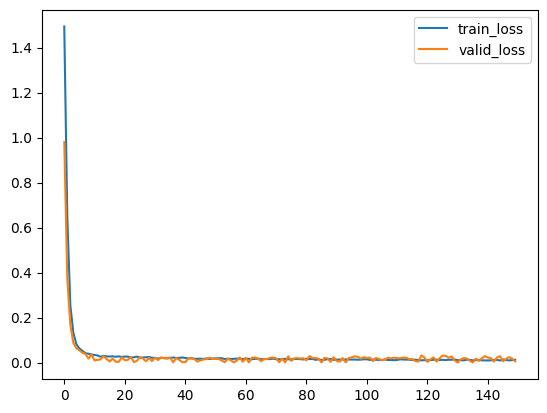

In [13]:
# train_lossとvalid_lossのプロット

plt.plot(grand_train_loss, label="train_loss")
plt.plot(grand_valid_loss, label="valid_loss")
plt.legend()
plt.show()

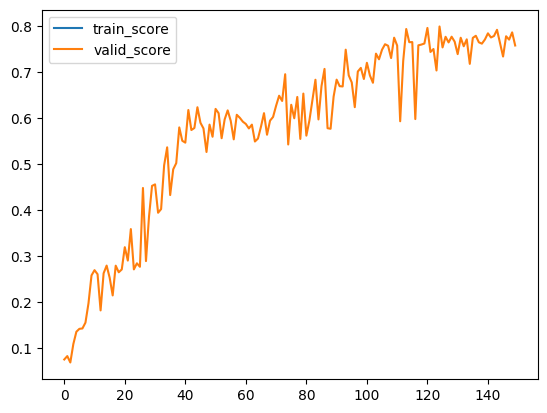

In [14]:
# train_scoreとvalid_scoreのプロット
plt.plot(grand_train_score, label="train_score")
plt.plot(grand_valid_score, label="valid_score")
plt.legend()
plt.show()

In [15]:
random.random()

0.5058658078203512